# Fully Convolutional Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the Training Data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

3432783872/3432776206 [==============================] - 151s 0us/step
X.shape: (6208, 216, 256, 1)
y.shape: (6208, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 3  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4
erosion_width = 0  # erode edges

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

#### Train the model fgbg model

In [7]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='conv_fgbg',
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/3
6983/6984 [============================>.] - ETA: 0s - loss: 0.1923 - model_loss: 0.0430 - model_1_loss: 0.0414 - model_2_loss: 0.0412 - model_3_loss: 0.0383 - model_acc: 0.9454 - model_1_acc: 0.9475 - model_2_acc: 0.9470 - model_3_acc: 0.9480
Epoch 00001: val_loss improved from inf to 0.53075, saving model to /data/models/2018-12-14_HeLa_S3_conv_fgbg.h5
6984/6984 [==============================] - 970s 139ms/step - loss: 0.1923 - model_loss: 0.0430 - model_1_loss: 0.0414 - model_2_loss: 0.0412 - model_3_loss: 0.0383 - model_acc: 0.9454 - model_1_acc: 0.9474 - model_2_acc: 0.9470 - model_3_acc: 0.9480 - val_loss: 0.5307 - val_model_loss: 0.2085 - val_model_1_loss: 0.0995 - val_model_2_loss: 0.0870 - val_model_3_loss: 0.1073 - val_model_acc: 0.9694 - val_model_1_acc: 0.9

### Next, Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [8]:
from deepcell import model_zoo

watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

#### Train the distance transform model

In [9]:
from deepcell.training import train_model_conv

watershed_model = train_model_conv(
    model=watershed_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='conv_watershed',
    test_size=test_size,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    transform=transform,
    distance_bins=distance_bins,
    erosion_width=erosion_width,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/3
6983/6984 [============================>.] - ETA: 0s - loss: 1.2269 - model_5_loss: 0.2983 - model_6_loss: 0.2896 - model_7_loss: 0.2916 - model_8_loss: 0.2894 - model_5_acc: 0.9206 - model_6_acc: 0.9207 - model_7_acc: 0.9234 - model_8_acc: 0.9282
Epoch 00001: val_loss improved from inf to 1.72429, saving model to /data/models/2018-12-14_HeLa_S3_conv_watershed.h5
6984/6984 [==============================] - 1437s 206ms/step - loss: 1.2268 - model_5_loss: 0.2983 - model_6_loss: 0.2896 - model_7_loss: 0.2916 - model_8_loss: 0.2894 - model_5_acc: 0.9206 - model_6_acc: 0.9207 - model_7_acc: 0.9234 - model_8_acc: 0.9282 - val_loss: 1.7243 - val_model_5_loss: 0.4245 - val_model_6_loss: 0.4110 - val_model_7_loss: 0.4141 - val_model_8_loss: 0.4160 - val_model_5_acc: 0.9661 - va

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6983/6984 [============================>.] - ETA: 0s - loss: 1.0952 - model_5_loss: 0.2630 - model_6_loss: 0.2577 - model_7_loss: 0.2587 - model_8_loss: 0.2566 - model_5_acc: 0.9195 - model_6_acc: 0.9219 - model_7_acc: 0.9287 - model_8_acc: 0.9325
Epoch 00002: val_loss improved from 1.72429 to 1.70995, saving model to /data/models/2018-12-14_HeLa_S3_conv_watershed.h5
6984/6984 [==============================] - 1417s 203ms/step - loss: 1.0953 - model_5_loss: 0.2630 - model_6_loss: 0.2577 - model_7_loss: 0.2588 - model_8_loss: 0.2566 - model_5_acc: 0.9195 - model_6_acc: 0.9218 - model_7_acc: 0.9287 - model_8_acc: 0.9325 - val_loss: 1.7100 - val_model_5_loss: 0.4096 - val_model_6_loss: 0.4096 - val_model_7_loss: 0.4145 - val_model_8_loss: 0.4167 - val_model_5_acc: 0.9660 - val_model_6_acc: 0.9670 - val_model_7_acc: 0.9659 - val_model_8_acc: 0.9641
Epoch 3/3
 340/6984 [>.............................] - ETA: 21:38 - loss: 1.0493 - model_5_loss: 0.2514 - model_6_loss: 0.2461 - model_7_loss:

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6415/6984 [==========================>...] - ETA: 1:51 - loss: 1.0585 - model_5_loss: 0.2538 - model_6_loss: 0.2488 - model_7_loss: 0.2495 - model_8_loss: 0.2466 - model_5_acc: 0.9226 - model_6_acc: 0.9224 - model_7_acc: 0.9308 - model_8_acc: 0.9349

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Run the model

In [10]:
# make predictions on testing data
test_images = watershed_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1552, 216, 256, 4)
segmentation mask shape: (1552, 216, 256, 2)


### Watershed post-processing

In [11]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1552, 216, 256, 1)


In [15]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [16]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

### Plot the Results

Image number: 1198


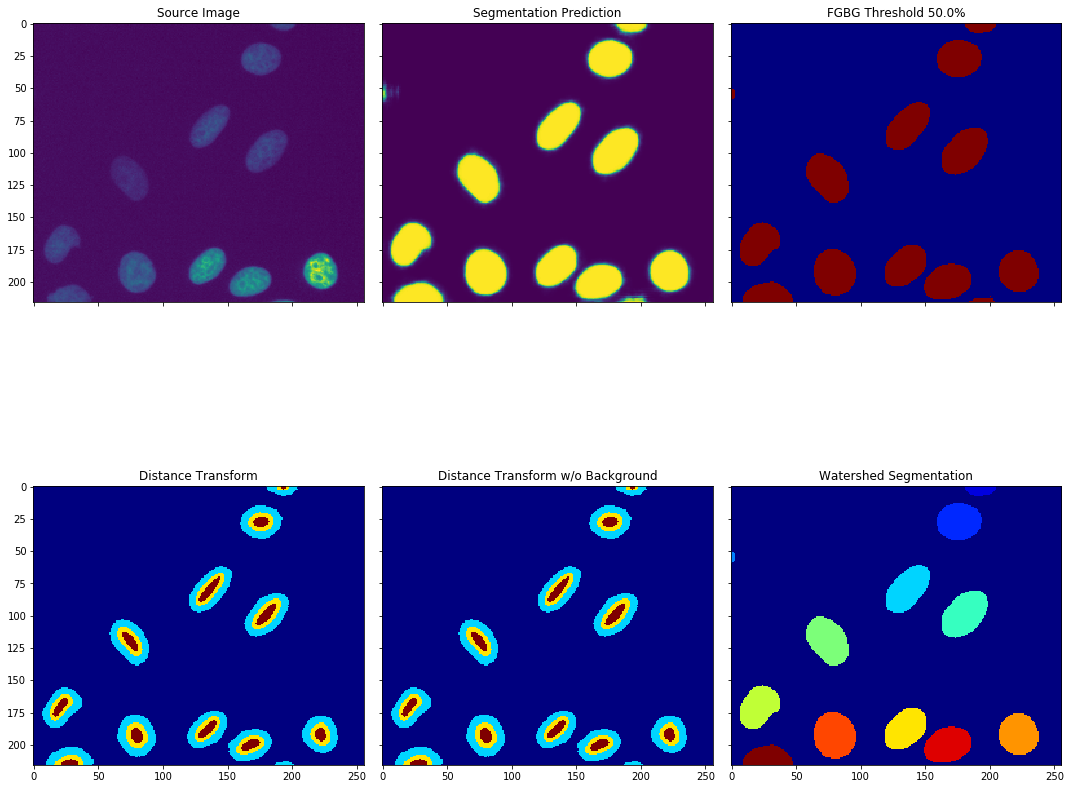

In [18]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(argmax_images[index, ..., 0], cmap='jet')
ax[3].set_title('Distance Transform')

ax[4].imshow(argmax_images_post_fgbg[index, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform w/o Background')

ax[5].imshow(watershed_images[index, ..., 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()